# Quantitative Structure Activity Relationship (QSAR) in R to understand the molecular properties responsible for mRNA Binding

The data and code for this study was taken from a recent study "Quantitative Structure–Activity Relationship (QSAR) Study Predicts Small-Molecule Binding to RNA Structure" https://pubs.acs.org/doi/10.1021/acs.jmedchem.2c00254. I have compiled a jupyter notebook to reproduce the model building. In the dataset, we have 48 molecules with 400+ decriptors. lnKD (dissociation constant is the dependent variable) 
So, this is a situation where number of data points (N) << (Number of Features or descriptors). Classical example of curse of dimensionality. 
Multiple Linear Regression seems to be a best approach for building model building. What important here is how we can reduce the dimension of the dataset. One of the approaches is to find best features for building predictive models in LASSO (Least Absolute Shrinkage and Selection operator) is an efficient method aka L1 regularization. A more detailed description can be found at https://www.publichealth.columbia.edu/research/population-health-methods/least-absolute-shrinkage-and-selection-operator-lasso.

Library Requirements for performing this analysis

"prospectr"

"glmnet"

## Steps for performing this analysis

1. Load the preprocessed dataset and perform the LASSO analysis to find the  number of features based on the minimum mean-sqaured error plotted against the lambda values. 

2. One of the challenges with this approach is you have to generate different combination of features from the lasso selected features to get the best model exlaining the structure activity relationship. This is not a trivial task. Domain knowledge plays a key role in selecting the appropriate model

2. Using the best model to predict the lnKD values


In [54]:
data_qsar <- read.csv("KD_refine.csv")

In [55]:
head(data_qsar)

,lnKD,rgyr,glob,AM1_dipole,AM1_E,AM1_HF,AM1_HOMO,apol,ASA.,ASA..1,⋯,vsurf_R,vsurf_W2,vsurf_W8,vsurf_Wp1,vsurf_Wp2,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,weinerPath
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,-16.26969,4.820693,0.1465251,21.54953,-207757.5,236.24567,-17.88922,90.86413,405.9668,122.86533,⋯,1.516588,1579.6133,13.565070,1592.945,1038.1184,215.3457,79.81318,18.71441,3.248806,6111
2,-12.51714,4.812603,0.1497168,19.21120,-210033.0,-42.75333,-16.38121,89.35196,388.9543,134.00852,⋯,1.523779,1571.8186,14.939443,1519.623,963.3679,191.6073,69.07973,14.05777,2.066936,6111
3,-12.45121,4.524976,0.1029352,25.71803,-143880.0,542.27912,-18.58516,71.85307,317.2251,65.44562,⋯,1.454466,1049.0908,5.502652,1313.306,814.9738,164.1943,62.12614,16.36669,4.427319,2700
4,-11.41974,4.199010,0.4194048,25.76304,-196863.4,-60.47815,-15.34944,81.90693,343.7094,171.51191,⋯,1.528474,1406.1336,15.357475,1350.648,770.1565,168.3968,83.09161,41.93077,20.083616,4989
5,-12.54856,4.508194,0.1117372,24.42179,-155728.6,317.78826,-17.55147,71.45014,342.6224,87.98411,⋯,1.450390,1313.0281,9.607074,1377.419,897.8370,184.2273,65.71518,13.31651,1.539569,2932
6,-12.48165,4.124427,0.1990713,14.22592,-151720.2,443.54318,-18.51158,79.24447,216.7050,35.61854,⋯,1.547151,874.4754,9.556666,1196.090,671.2119,135.7255,52.62777,13.87811,2.658363,3234


In [56]:
#Let's create a function for evaluating results 
#The function takes true and predicted as 

evaluate_results <- function(true, predicted, df) {
    SSE <- ((true-predicted)^2)
    SST <- ((true-mean(true))^2)
    R2 <- 1 - SSE/SST
    RMSE <- sqrt(SSE/nrow(df))
            
    data.frame(
        RMSE = RMSE, 
        R_squared = R2)
    
}


In [57]:
#remotes::install_github("l-ramirez-lopez/prospectr")

In [58]:
library(prospectr)

In [59]:
xspace <- data_qsar[,-1]
ks <- kenStone(as.matrix(xspace), k=12, metric = "mahal",pc=0.99, .center =
TRUE, .scale = FALSE)
ks$test
trainid <- ks$test

[1]  1  3  4  5  7  8  9 11 12 14 15 16 17 18 20 21 22 23 25 26 28 29 30 31 33
[26] 35 37 38 40 41 42 43 44 45 46 47

In [60]:
#After performing let's divide the data into training and testset

training_set <- data_qsar[trainid,]
test_set <- data_qsar[-trainid, ]


x_train <- as.matrix(training_set[-1])
y_train <- data.matrix(training_set[1])
x_test <- as.matrix(test_set[-1])
y_test <- as.matrix(test_set[1])


In [61]:
#install.packages("glmnet")

In [62]:
library("glmnet")

[1] 100


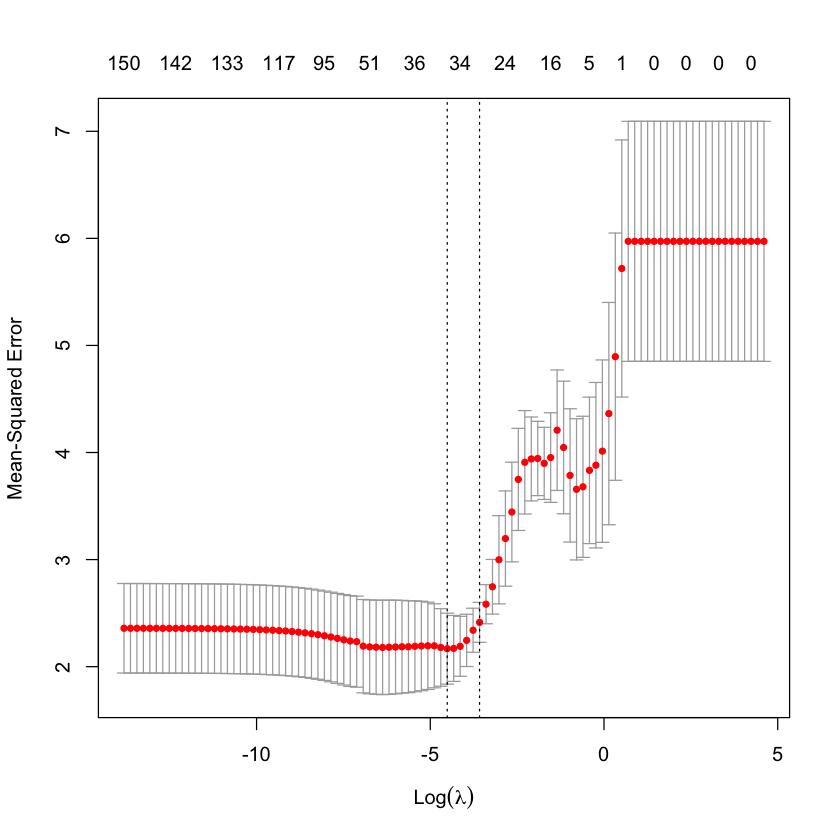

[1] -1.601305e+01 -3.529281e-03  1.488274e-01 -6.282926e-01 -3.843261e-07
 [6] -7.434999e-02  2.911624e-01 -4.376213e-02 -3.828838e-06 -3.964591e-03
[11] -1.388672e+02  2.794962e+00 -9.716744e+00 -4.161604e+00 -4.930742e-01
[16] -1.970703e-01 -1.489831e-01 -6.033860e-03  1.575345e-03 -2.094944e-05
[21]  1.933452e+01 -7.427365e-03 -4.311557e-04 -3.132006e-02  2.928921e-03
[26] -9.510275e-03  4.189982e-02  1.304012e-01 -7.794417e-03 -9.145612e-02
[31] -1.779423e-01 -2.394366e-03  2.257966e-01  5.394498e-01  8.406075e-01
[36]  2.343955e-02

[1] "AM1_HF"        "ast_violation" "b_max1len"     "DCASA"        
 [5] "dipoleY"       "dipoleZ"       "E_ang"         "E_rnb"        
 [9] "E_rsol"        "E_strain"      "GCUT_PEOE_0"   "GCUT_PEOE_1"  
[13] "GCUT_PEOE_2"   "GCUT_SLOGP_0"  "h_pKb"         "h_pstates"    
[17] "PEOE_VSA.0"    "PEOE_VSA.1.1"  "PEOE_VSA_POS"  "petitjean"    
[21] "SlogP_VSA3"    "SlogP_VSA8"    "SMR_VSA4"      "SMR_VSA7"     
[25] "vsa_acc"       "vsa_other"     "vsurf_A"       "vsurf_DD13"   
[29] "vsurf_DD23"    "vsurf_DW12"    "vsurf_DW13"    "vsurf_ID1"    
[33] "vsurf_ID3"     "vsurf_IW2"     "vsurf_IW7"

,lnKD,lnKD.1
,<dbl>,<dbl>
2,0.34456179,-2.131984e+00
6,0.22400086,-4.747976e-01
10,0.01475028,9.998310e-01
13,0.04390299,9.913746e-01
19,0.25568366,5.427119e-01
24,0.48732364,8.598265e-01
27,0.20593396,-2.150123e+04
32,0.96412899,4.833237e-01
34,0.31965730,-3.522995e+01


,lnKD,lnKD.1
,<dbl>,<dbl>
1,0.025316068,0.9988648
3,0.014286497,0.9845556
4,0.001797751,0.9990036
5,0.025991215,0.9607456
7,0.010787365,0.9965625
8,0.025305323,0.8781310
9,0.007877363,0.9954080
11,0.022760976,0.8130770
12,0.016993506,0.9995385


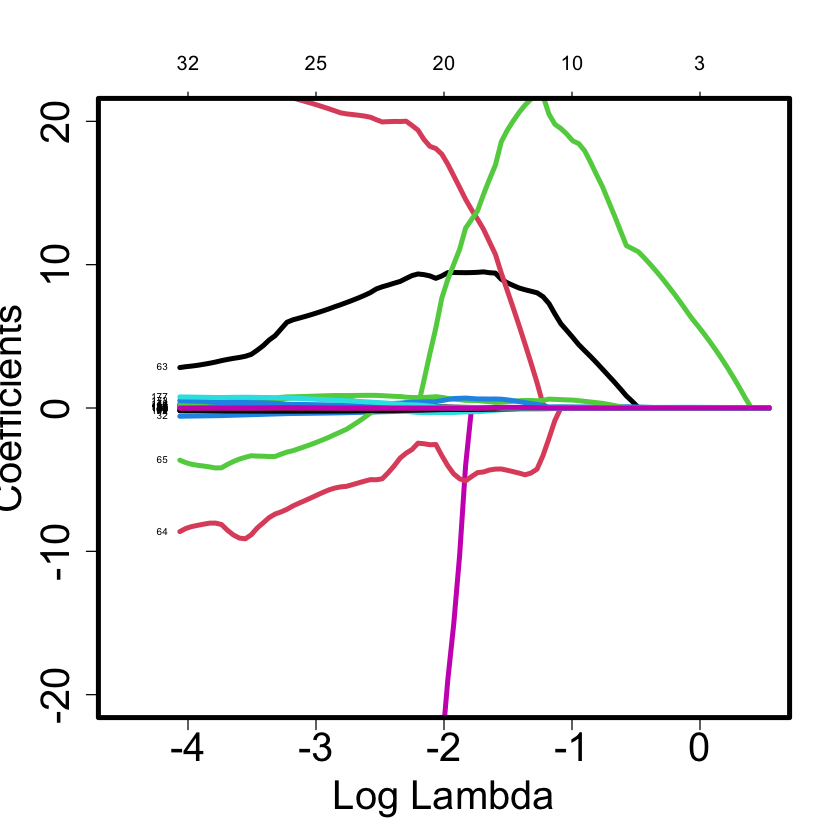

In [63]:
set.seed(1)
lambdas <- 10^seq(2, -6, length = 100)
print (length(lambdas))
# use sv.glmnet to find the best lambda for lasso from 5-fold cv
lasso_reg <- cv.glmnet(x_train, y_train, alpha = 1, lambda = lambdas,
standardize = TRUE, nfolds = 5)
plot(lasso_reg)
# plot the shrinkage graph with multiple lambda values
lasso_model <- glmnet(x_train, y_train, alpha = 1, nlambda =100,standardize =
TRUE)

p1 <- plot(lasso_model,xvar="lambda",label = T, lwd=4,cex.lab=
2,cex.axis=2,xlim = c(-4.5,0.5), ylim=c(-20,20))

p1.lty=2
box(lwd=4)
# chose the lambda with lowest mean-squrared error from cv
lambda_best_lasso <- lasso_reg$lambda.min

# build the lasso regression model using selected descriptors
lasso_model <- glmnet(x_train, y_train, alpha = 1, lambda
=lambda_best_lasso,standardize = TRUE)

# find the non-zero coefficients and their names
lasso.coef <- predict(lasso_model,type="coefficients")
lasso.coef[lasso.coef!=0]
lasso_nonzerocoef <- predict(lasso_model,type="nonzero")
colnames(data_qsar[,lasso_nonzerocoef$s0+1])
# model evaluation on lasso model using all non-zero descriptors
lasso_fittings <- predict(lasso_model, s = lambda_best_lasso, newx = x_train)
lasso_predictions <- predict(lasso_model, s = lambda_best_lasso, newx =
x_test)
evaluate_results(y_test, lasso_predictions, test_set)
evaluate_results(y_train, lasso_fittings, training_set)

In [64]:
print (append(lasso_nonzerocoef$s0+1, 1, 0))

data_step <- training_set[,append(lasso_nonzerocoef$s0+1, 1, 0)]

 [1]   1   6  13  33  39  44  45  46  51  52  56  64  65  66  67  80  81 100 108
[20] 117 118 135 138 143 145 149 152 153 161 162 163 164 173 174 178 183


In [65]:
m <- 3
idx <- combn(rep(1:(length(data_step)-1)),m)


In [66]:
# Your R code here
suppressWarnings({
results <- NULL
for (i in 1:ncol(idx)) {
data_exhau <- data_step[,append(idx[,i]+1,1,0)] 
mdl_exhau <- lm(lnKD~.,data=data_exhau)
predict <- predict(mdl_exhau,newdata = test_set)
fitted <- mdl_exhau$fitted.values
a <- evaluate_results(test_set$lnKD,predict,test_set)
b <- evaluate_results(training_set$lnKD,fitted,training_set)

    result <- data.frame(test=a, 
                     train=b
) 
    results <- rbind(results,result)
}
# idrows find all candidates with top performance, and print out the model summary for statistical significance check
})



Call:
lm(formula = "lnKD~1+PEOE_VSA_POS+vsurf_DW12+vsa_other+vsurf_ID3", 
    data = training_set)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7574 -0.6231  0.1389  0.5923  2.4163 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -10.03906    0.88572 -11.334 1.48e-12 ***
PEOE_VSA_POS  -0.01521    0.00232  -6.557 2.54e-07 ***
vsurf_DW12    -0.37242    0.12798  -2.910  0.00663 ** 
vsa_other      0.05441    0.01029   5.286 9.46e-06 ***
vsurf_ID3      1.68556    0.46762   3.605  0.00108 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.237 on 31 degrees of freedom
Multiple R-squared:  0.7686,	Adjusted R-squared:  0.7387 
F-statistic: 25.74 on 4 and 31 DF,  p-value: 1.817e-09


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font metrics unknown for character 0xa”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font metrics unknown for character 0xa”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font metrics unknown for character 0xa”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font metrics unknown for character 0xa”


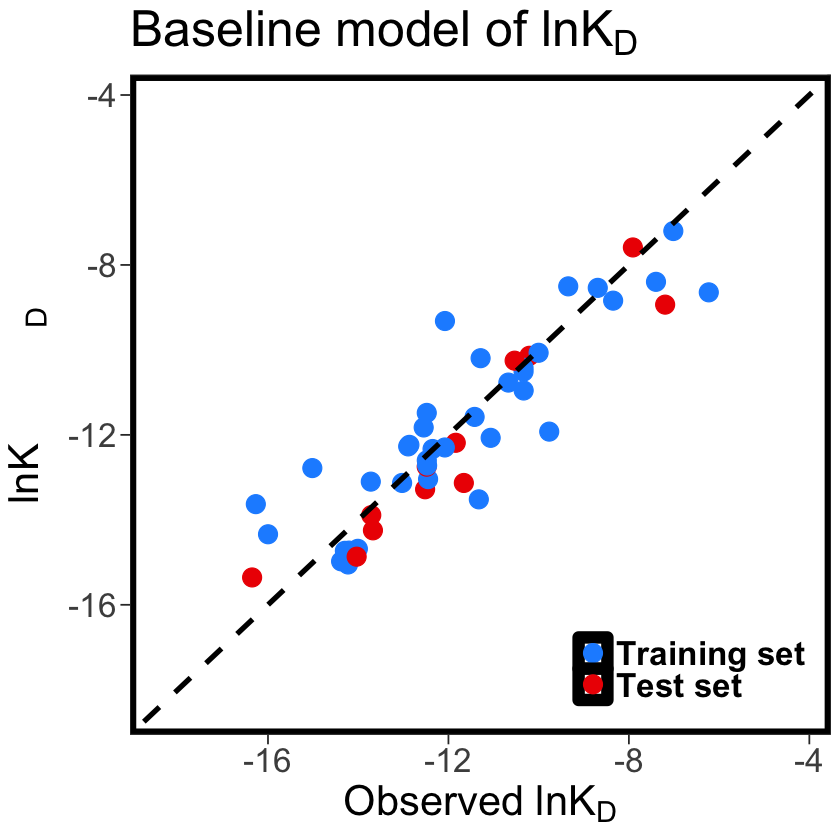

In [67]:

#idrows <- which(results$test.R_squared>=0.70&results$train.R_squared>=.70)

#for (val in idrows) {
#data_exhau <- data_step[,append(idx[,val-1]+1,1,0)] 
#    mdl_exhau <- lm(lnKD~.,data=data_exhau)
    
#s <- summary(mdl_exhau)
# print(s)
# print(val)
# cat("R2_test:", results[val,2])
#}

#s <- summary(mdl_exhau) 
#print(s)
#print(val)
#print("R2_test:", results[val,2])

# plot the curve for the top model
library(ggplot2)
# load the model
mdl <- lm(formula = "lnKD~1+PEOE_VSA_POS+vsurf_DW12+vsa_other+vsurf_ID3", data = training_set) 
summary(mdl)
predict <- predict(mdl,newdata = data_qsar) 
id <- numeric(48)
id[-trainid] <- 1
data_plot <- cbind(predict,data_qsar$lnKD,id)
colnames(data_plot) <- c("predict", "obs","id")
ggplot(as.data.frame(data_plot), aes(x=obs,y=predict))+ ggtitle(expression("Baseline model of lnK"[D]*"")) + xlab(expression("Observed lnK"[D]*"")) + ylab(expression("Predicted
lnK"[D]*""))+
# THE DATA POINT
geom_point(aes(color = factor(id)),size = 5,alpha =1) + xlim(min(data_qsar$lnKD)-2,max(data_qsar$lnKD)+2)+ ylim(min(data_qsar$lnKD)-2,max(data_qsar$lnKD)+2)+
scale_color_manual(labels = c("Training set", "Test set"), values =
c("dodgerblue", "red2"))+
# title
theme_bw()+ theme(axis.ticks.length=unit(.4,"lines"))+ theme(panel.grid.major = element_blank(),
panel.grid.minor = element_blank())+ theme(axis.text.y = element_text(size = 20),
axis.text.x = element_text(size=20),
axis.title = element_text(size = 25,face = 'bold'),title =element_text(size = 25,face = 'bold') )+
# legend
theme(legend.title = element_blank())+
theme(legend.text = element_text(colour="black", size=20, face="bold"))+ theme(legend.position = c(0.80, 0.1))+
# rec
theme(panel.background = element_rect(colour = "black", size = 3.5))+ # ref line
geom_abline(intercept = 0, slope = 1, color="black",
linetype="dashed", size=1.5) 
ggsave("KDmdl.tiff", units="in", width=8, height=8, dpi=600)
    


